In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch.nn.functional as F
import torch

from common import metrics

tensor(1300)


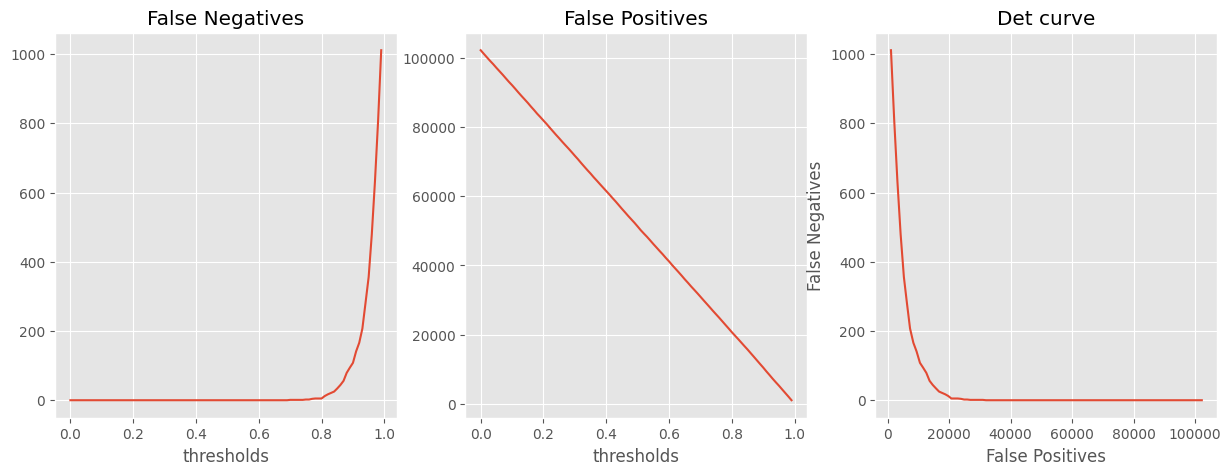

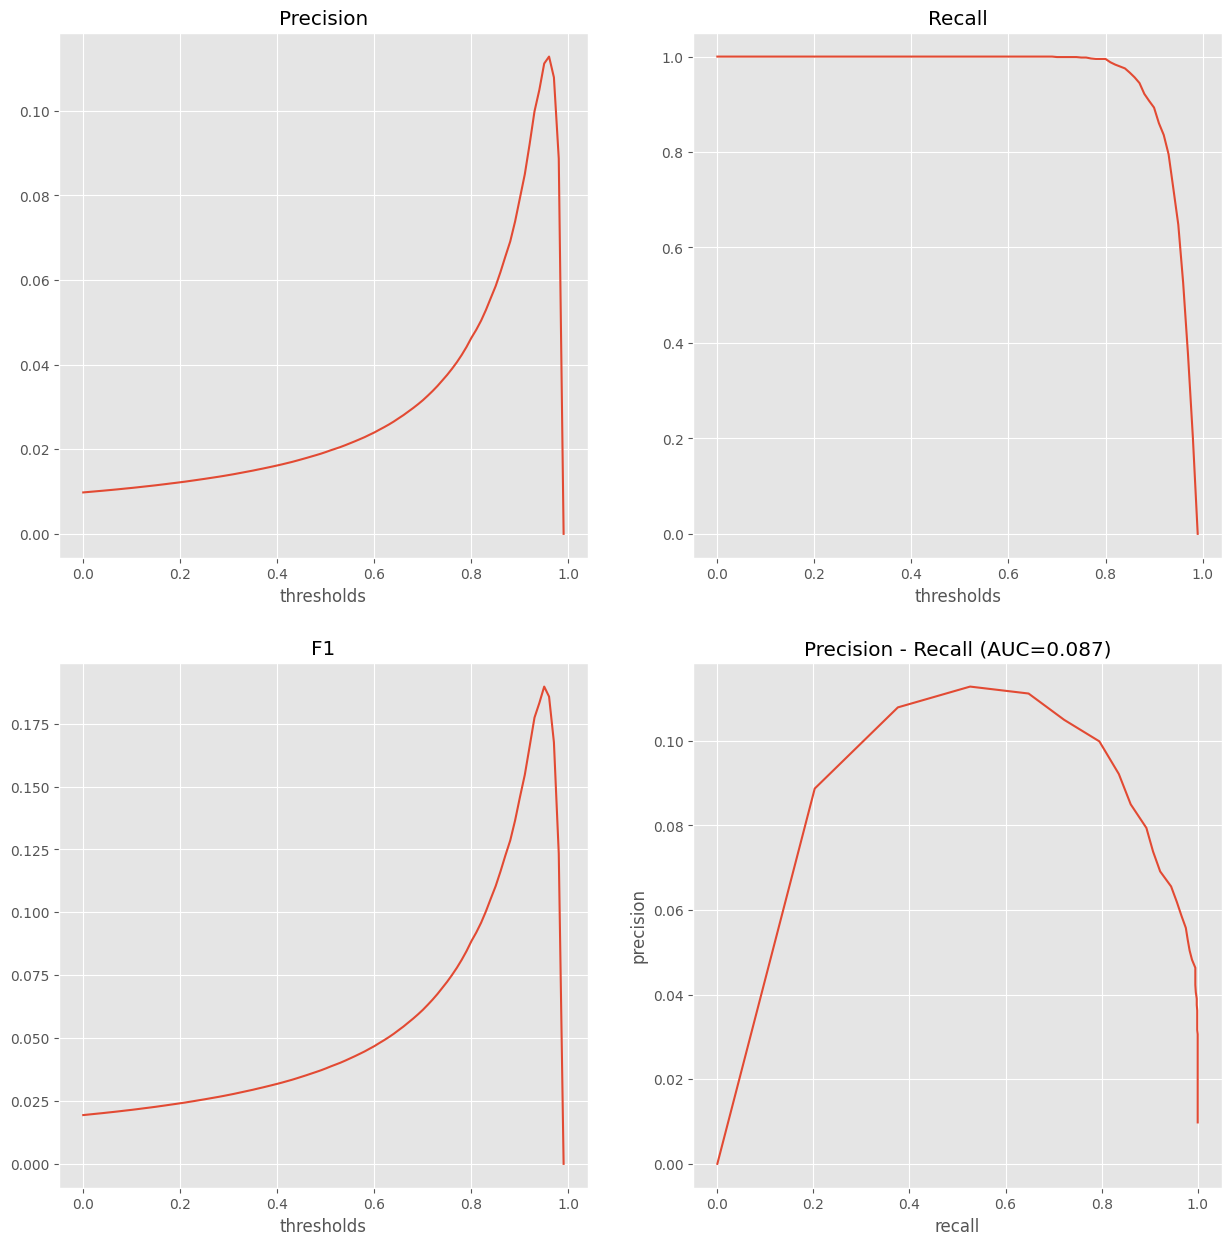

In [8]:
bs = 128
wl = 1024

def cm_win(winsize: int):
    signals = torch.rand(bs, wl)
    gt_labels = (torch.rand_like(signals) > 0.99).to(torch.int)

    print(gt_labels.sum())
    fp, fn, th = metrics.errors_curve(signals, gt_labels, winsize)
    pr, rc, f1 = metrics.precision_recall_f1(fp, fn)

    metrics.plot_errors_curve(fp, fn, th)
    metrics.plot_precision_recall_f1_curve(pr, rc, f1, th)


cm_win(12)